In [1]:
###############################################################################
#
#	prepare.py		Generates YOLO datasets from MNIST datasets
#
#
#  Copyright (c) 2023 by Alexander M. Albertian, <assa@4ip.ru>.
#  All rights reserved.
###############################################################################

import set_working_directory
import sys
import os
import shutil
#os.environ[ 'CUDA_VISIBLE_DEVICES' ] = '0'
#import tensorflow as tf
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from yolov3.classes import *
import input_data

Using custom weights: './checkpoints/yolov3_custom_tiny'
Using saved model: './checkpoints/yolov3-tiny-416'
Using 10 class(es) from: 'mnist/mnist.names'


In [2]:
#NUM_CLASSES = 10
SIZE = TRAIN_INPUT_SIZE		# size of generated images
IMAGES_NUM_TRAIN = 10000	# train dataset size
IMAGES_NUM_TEST = 2000		# test dataset size

data_sets = input_data.read_data_sets( train_dir = "mnist" )

Extracting mnist\train-images-idx3-ubyte.gz
Size: num_images = 60000, rows = 28, cols = 28
Extracting mnist\train-labels-idx1-ubyte.gz
Size: num_items = 60000
Extracting mnist\t10k-images-idx3-ubyte.gz
Size: num_images = 10000, rows = 28, cols = 28
Extracting mnist\t10k-labels-idx1-ubyte.gz
Size: num_items = 10000


In [3]:
TO_DISPLAY = 6

train_path = "./mnist/train"
train_num = data_sets.train.num_examples
test_path = "./mnist/test"
test_num = data_sets.test.num_examples

Train size: 55000


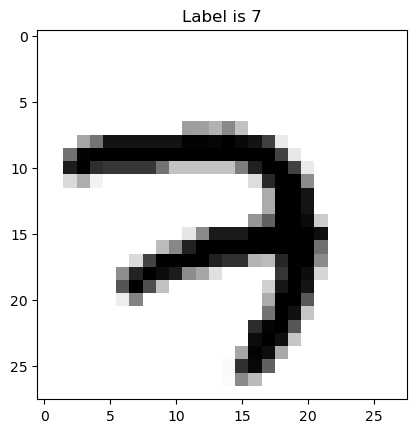

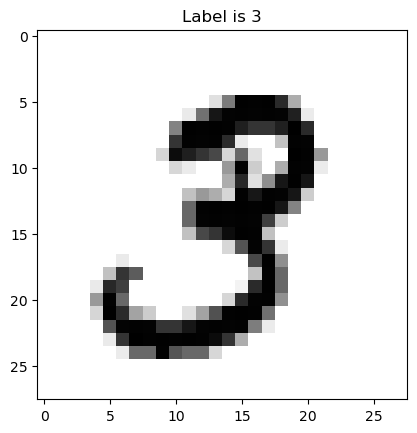

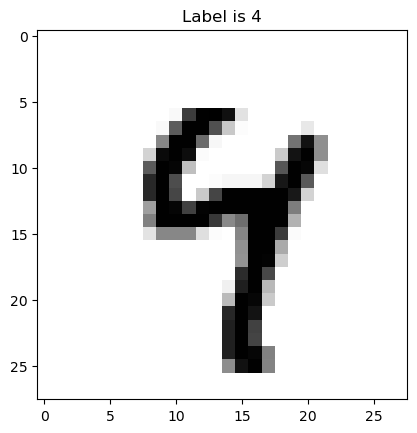

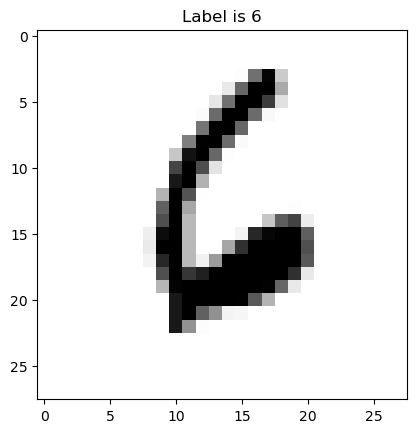

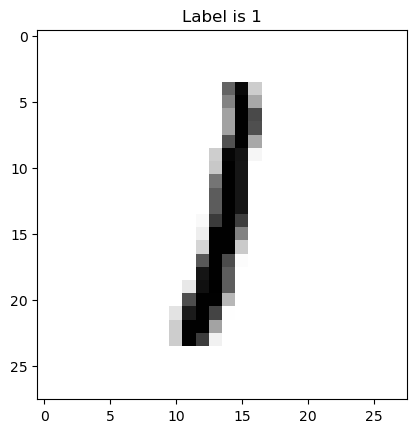

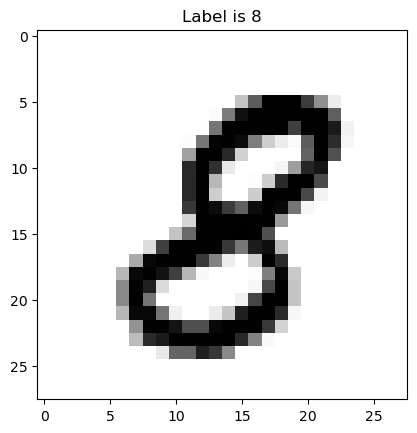

	[ 0 ]: 5444
	[ 1 ]: 6179
	[ 2 ]: 5470
	[ 3 ]: 5638
	[ 4 ]: 5307
	[ 5 ]: 4987
	[ 6 ]: 5417
	[ 7 ]: 5715
	[ 8 ]: 5389
	[ 9 ]: 5454


In [4]:
print( f"Train size: {train_num}" )

#shutil.rmtree( train_path )
if not os.path.exists( train_path ):
	reexport = True
	os.mkdir( train_path )
else:
	reexport = False

num = [ 0 ] * NUM_CLASSES
ds_images, ds_labels = data_sets.train.next_batch( train_num )

for i, ( pixels, label ) in enumerate( zip( ds_images, ds_labels ) ):
	# pixels is an array of 8-bits pixels
	# This array is 1D with length 784
	# The pixel intensity values are integers from 0 to 255

	# Reshape the array into 28 x 28 array ( 2-dimensional array )
	pixels = pixels.reshape( ( 28, 28 ) ).astype( np.uint8 )
	# Invert image
#	pixels ^= 255

	# Plot
	if ( i < TO_DISPLAY ):
		plt.title( 'Label is {label}'.format( label = label ) )
		plt.imshow( pixels, cmap = 'gray' )
		plt.show( )

	if reexport:
		path = train_path + f"/{label}_{num[ label ]:04d}.pgm"
	#       print( path )
		cv2.imwrite( path, pixels )

	num[ label ] += 1

for i in range( len( num ) ):
	print( "\t[ %d ]: %d" %( i, num[ i ] ) )

Test size: 10000


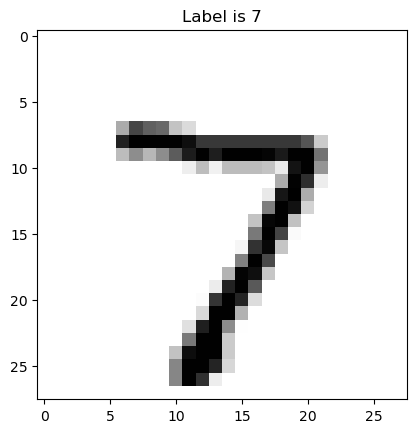

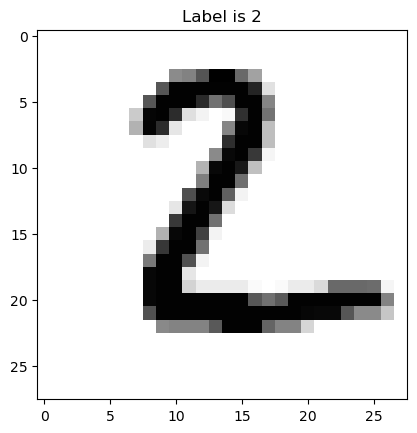

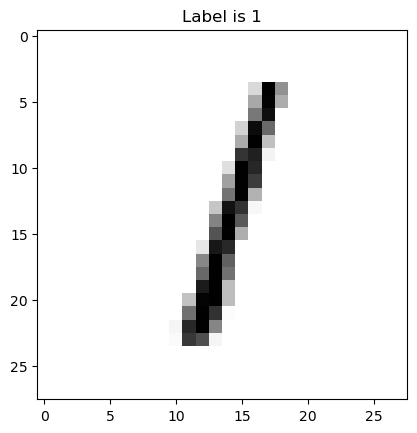

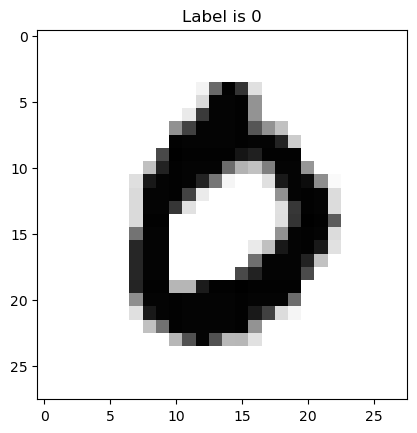

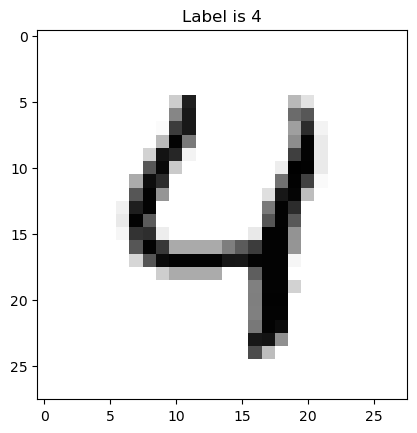

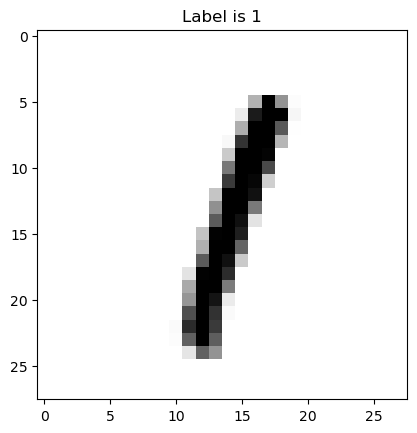

	[ 0 ]: 980
	[ 1 ]: 1135
	[ 2 ]: 1032
	[ 3 ]: 1010
	[ 4 ]: 982
	[ 5 ]: 892
	[ 6 ]: 958
	[ 7 ]: 1028
	[ 8 ]: 974
	[ 9 ]: 1009


In [5]:
print( f"Test size: {test_num}" )

#shutil.rmtree( test_path )
if not os.path.exists( test_path ):
	reexport = True
	os.mkdir( test_path )
else:
	reexport = False

num = [ 0 ] * NUM_CLASSES
ds_images, ds_labels = data_sets.test.next_batch( test_num )

for i, ( pixels, label ) in enumerate( zip( ds_images, ds_labels ) ):
	# pixels is an array of 8-bits pixels
	# This array is 1D with length 784
	# The pixel intensity values are integers from 0 to 255

	# Reshape the array into 28 x 28 array ( 2-dimensional array )
	pixels = pixels.reshape( ( 28, 28 ) ).astype( np.uint8 )
	# Invert image
#	pixels ^= 255

	# Plot
	if ( i < TO_DISPLAY ):
		plt.title( 'Label is {label}'.format( label = label ) )
		plt.imshow( pixels, cmap = 'gray' )
		plt.show( )

	if reexport:
		path = test_path + f"/{label}_{num[ label ]:04d}.pgm"
	#       print( path )
		cv2.imwrite( path, pixels )

	num[ label ] += 1

for i in range( len( num ) ):
	print( "\t[ %d ]: %d" %( i, num[ i ] ) )

In [6]:
images_num_train = IMAGES_NUM_TRAIN
images_num_test = IMAGES_NUM_TEST

image_sizes = [ 3, 6, 3 ]     # small, medium, big

In [7]:
def compute_iou( box1, box2 ):
	# xmin, ymin, xmax, ymax
	A1 = ( box1[ 2 ] - box1[ 0 ] ) * ( box1[ 3 ] - box1[ 1 ] )
	A2 = ( box2[ 2 ] - box2[ 0 ] ) * ( box2[ 3 ] - box2[ 1 ] )

	xmin = max( box1[ 0 ], box2[ 0 ] )
	ymin = max( box1[ 1 ], box2[ 1 ] )
	xmax = min( box1[ 2 ], box2[ 2 ] )
	ymax = min( box1[ 3 ], box2[ 3 ] )

	if ymin >= ymax or xmin >= xmax: return 0
	return  ( ( xmax - xmin ) * ( ymax - ymin ) ) / ( A1 + A2 )

In [8]:
def make_image( data, image, label, ratio = 1 ):
	blank = data[ 0 ]
	boxes = data[ 1 ]
	labels = data[ 2 ]

	# Reshape into 28 x 28 2D array
	cv_image = image.reshape( ( 28, 28 ) ).astype( np.uint8 )

#	cv_image = cv2.cvtColor( cv_image, cv2.COLOR_GRAY2BGR )
	cv_image = cv2.resize( cv_image, ( int( 28 * ratio ), int( 28 * ratio ) ) )
#	h, w, c = cv_image.shape
	h, w = cv_image.shape

	while True:
		xmin = np.random.randint( 0, SIZE - w, 1 )[ 0 ]
		ymin = np.random.randint( 0, SIZE - h, 1 )[ 0 ]
		xmax = xmin + w
		ymax = ymin + h
		box = [ xmin, ymin, xmax, ymax ]

		iou = [ compute_iou( box, b ) for b in boxes ]
		if max( iou ) < 0.02:
			boxes.append( box )
			labels.append( label )
			break

#	for i in range( w ):
#		for j in range( h ):
#			x = xmin + i
#			y = ymin + j
#			blank[ y ][ x ] &= cv_image[ j ][ i ]
	locs = np.where( cv_image != 255 )
	blank[ locs[ 0 ] + ymin, locs[ 1 ] + xmin ] = cv_image[ locs[ 0 ], locs[ 1 ], None ]

#	cv2.rectangle( blank, ( xmin, ymin ), ( xmax, ymax ), [ 0, 0, 255 ], 2 )
	return blank


In [9]:
for dataset,file in [ data_sets.train, 'train' ],[ data_sets.test, 'test' ]:
#	images_path = os.getcwd( )+f"/mnist_{file}"
#	labels_txt = os.getcwd( )+f"/mnist_{file}.txt"
	images_path = f"./mnist_{file}"
	labels_txt = f"./mnist_{file}.txt"

#	images_num = dataset.num_examples
	if dataset == data_sets.train: images_num = images_num_train
	else: images_num = images_num_test

	if os.path.exists( images_path ): shutil.rmtree( images_path )
	os.mkdir( images_path )

	print( f"{file} ( {images_num} ): {images_path}, {labels_txt}" )

	# ratios small, medium, big objects
	RATIOS = [ [ 0.5, 0.8 ], [ 1., 1.5, 2. ], [ 3., 4. ] ]

	with open( labels_txt, "wb" ) as wf:
		pperc = -1
		for image_num in range( images_num ):
		#	image_path = os.path.realpath( os.path.join( images_path, "%06d.jpg" %( image_num + 1 ) ) )
			image_path = '/'.join( [ images_path, "%06d.jpg" %( image_num + 1 ) ] )

			annotation = image_path
			blanks = np.ones( shape = [ SIZE, SIZE, 3 ], dtype = np.uint8 ) * 255
			bboxes = [ [ 0, 0, 1, 1 ] ]
			labels = [ 0 ]
			data = [ blanks, bboxes, labels ]
			bboxes_num = 0

			ds_images, ds_labels = dataset.next_batch( sum( image_sizes ) )
			ds_iter = iter( zip( ds_images, ds_labels ) )

			for i in range( len( RATIOS ) ):
				N = random.randint( 0, image_sizes[ i ] )
				if N != 0: bboxes_num += 1
				for _ in range( N ):
					ratio = random.choice( RATIOS[ i ] )
					( ds_image, ds_label ) = next( ds_iter )
					data[ 0 ] = make_image( data, ds_image, ds_label, ratio )

			if bboxes_num == 0:
				bboxes_num += 1
				i = random.randint( 0, len( RATIOS ) - 1 )
				ratio = random.choice( RATIOS[ i ] )
				( ds_image, ds_label ) = next( ds_iter )
				data[ 0 ] = make_image( data, ds_image, ds_label, ratio )

			cv2.imwrite( image_path, data[ 0 ] )
			for i in range( len( labels ) ):
				if i == 0: continue
				xmin = str( bboxes[ i ][ 0 ] )
				ymin = str( bboxes[ i ][ 1 ] )
				xmax = str( bboxes[ i ][ 2 ] )
				ymax = str( bboxes[ i ][ 3 ] )
				class_ind = str( labels[ i ] )
				annotation += ' ' + ','.join( [ xmin, ymin, xmax, ymax, str( class_ind ) ] )

		#	print( "=> %s" %annotation )
			perc = ( 100 * ( image_num + 1 ) ) // images_num
			if perc != pperc:
				print( "%d%%\r" %perc, end = '' )
				pperc = perc
			wf.write( bytes( annotation + "\n", encoding = 'utf-8' ) )

print( "Done!" )


train ( 10000 ): ./mnist_train, ./mnist_train.txt
test ( 2000 ): ./mnist_test, ./mnist_test.txt
Done!
